In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import numpy as np
import tqdm
from torchvision.models import ResNet18_Weights
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight

In [2]:
from src.config import SPLIT_TRAIN_DIR, SPLIT_VAL_DIR, SPLIT_TEST_DIR

In [27]:
class MolecularSubtypesDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, minority_classes=None, transform=None):
        if minority_classes is None:
            minority_classes = []
        self.data_dir = data_dir
        self.transform = transform
        self.data = datasets.ImageFolder(data_dir, transform=transform)
        self.classes = self.data.classes
        self.minority_classes = minority_classes

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

    def targets(self):
        return self.data.targets


In [28]:
# Load dataset from directory

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

augment_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train = MolecularSubtypesDataset(SPLIT_TRAIN_DIR, transform=transform)
train_loader = torch.utils.data.DataLoader(train, batch_size=64, shuffle=True)

In [29]:
classes = train.classes


# Calcular la frecuencia de cada clase
counter = Counter(train.targets)
min_class = min(counter, key=counter.get)

class_weights = compute_class_weight('balanced', classes=np.unique(train.targets), y=train.targets)

class_weights = torch.tensor(class_weights, dtype=torch.float32)


TypeError: 'method' object is not iterable

In [5]:
device = torch.accelerator.current_accelerator() if torch.accelerator.is_available() else torch.device("cpu")

In [6]:
class_weights = class_weights.to(device)

In [7]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, precision_score, recall_score, f1_score

In [8]:
# Try transfer learning

model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

# freeze all layers

for param in model.parameters():
    param.requires_grad = False


model.fc = nn.Sequential(
    nn.Linear(512, 256),  # Ajuste de dimensiones
    nn.ReLU(),
    nn.Dropout(0.2),

    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(0.4),

    nn.Linear(128, len(classes))  # Ajuste de dimensiones
)

In [9]:
model = model.to(device)

criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

In [10]:
for epoch in range(50):
    print("Epoch {}/{}".format(epoch + 1, 50))
    print("-" * 10)

    model.train()
    running_loss = 0.0

    for inputs, labels in tqdm.tqdm(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)

    print("Loss: {:.4f}".format(epoch_loss))


Epoch 1/50
----------


100%|██████████| 17/17 [00:19<00:00,  1.15s/it]


Loss: 1.4130
Epoch 2/50
----------


100%|██████████| 17/17 [00:18<00:00,  1.10s/it]


Loss: 1.3885
Epoch 3/50
----------


100%|██████████| 17/17 [00:18<00:00,  1.10s/it]


Loss: 1.3796
Epoch 4/50
----------


100%|██████████| 17/17 [00:18<00:00,  1.10s/it]


Loss: 1.3718
Epoch 5/50
----------


100%|██████████| 17/17 [00:19<00:00,  1.13s/it]


Loss: 1.3610
Epoch 6/50
----------


100%|██████████| 17/17 [00:18<00:00,  1.10s/it]


Loss: 1.3450
Epoch 7/50
----------


100%|██████████| 17/17 [00:18<00:00,  1.12s/it]


Loss: 1.3438
Epoch 8/50
----------


100%|██████████| 17/17 [00:19<00:00,  1.15s/it]


Loss: 1.3271
Epoch 9/50
----------


100%|██████████| 17/17 [00:18<00:00,  1.11s/it]


Loss: 1.3125
Epoch 10/50
----------


100%|██████████| 17/17 [00:19<00:00,  1.15s/it]


Loss: 1.2769
Epoch 11/50
----------


100%|██████████| 17/17 [00:18<00:00,  1.10s/it]


Loss: 1.2534
Epoch 12/50
----------


100%|██████████| 17/17 [00:18<00:00,  1.10s/it]


Loss: 1.2350
Epoch 13/50
----------


100%|██████████| 17/17 [00:18<00:00,  1.10s/it]


Loss: 1.2434
Epoch 14/50
----------


100%|██████████| 17/17 [00:18<00:00,  1.10s/it]


Loss: 1.1816
Epoch 15/50
----------


100%|██████████| 17/17 [00:18<00:00,  1.11s/it]


Loss: 1.1917
Epoch 16/50
----------


100%|██████████| 17/17 [00:19<00:00,  1.13s/it]


Loss: 1.1786
Epoch 17/50
----------


100%|██████████| 17/17 [00:18<00:00,  1.11s/it]


Loss: 1.1580
Epoch 18/50
----------


100%|██████████| 17/17 [00:19<00:00,  1.12s/it]


Loss: 1.1741
Epoch 19/50
----------


100%|██████████| 17/17 [00:20<00:00,  1.18s/it]


Loss: 1.1205
Epoch 20/50
----------


100%|██████████| 17/17 [00:20<00:00,  1.21s/it]


Loss: 1.0929
Epoch 21/50
----------


100%|██████████| 17/17 [00:20<00:00,  1.18s/it]


Loss: 1.0417
Epoch 22/50
----------


100%|██████████| 17/17 [00:19<00:00,  1.14s/it]


Loss: 0.9935
Epoch 23/50
----------


100%|██████████| 17/17 [00:20<00:00,  1.21s/it]


Loss: 0.9731
Epoch 24/50
----------


100%|██████████| 17/17 [00:18<00:00,  1.10s/it]


Loss: 0.9737
Epoch 25/50
----------


100%|██████████| 17/17 [00:19<00:00,  1.15s/it]


Loss: 0.9754
Epoch 26/50
----------


100%|██████████| 17/17 [00:19<00:00,  1.14s/it]


Loss: 0.9624
Epoch 27/50
----------


100%|██████████| 17/17 [00:19<00:00,  1.13s/it]


Loss: 0.9439
Epoch 28/50
----------


100%|██████████| 17/17 [00:19<00:00,  1.13s/it]


Loss: 0.9885
Epoch 29/50
----------


100%|██████████| 17/17 [00:19<00:00,  1.14s/it]


Loss: 0.9620
Epoch 30/50
----------


100%|██████████| 17/17 [00:18<00:00,  1.11s/it]


Loss: 0.9273
Epoch 31/50
----------


100%|██████████| 17/17 [00:18<00:00,  1.12s/it]


Loss: 0.8702
Epoch 32/50
----------


100%|██████████| 17/17 [00:19<00:00,  1.12s/it]


Loss: 0.9076
Epoch 33/50
----------


100%|██████████| 17/17 [00:19<00:00,  1.13s/it]


Loss: 0.8224
Epoch 34/50
----------


100%|██████████| 17/17 [00:19<00:00,  1.14s/it]


Loss: 0.7796
Epoch 35/50
----------


100%|██████████| 17/17 [00:19<00:00,  1.12s/it]


Loss: 0.7617
Epoch 36/50
----------


100%|██████████| 17/17 [00:19<00:00,  1.12s/it]


Loss: 0.7338
Epoch 37/50
----------


100%|██████████| 17/17 [00:19<00:00,  1.12s/it]


Loss: 0.7348
Epoch 38/50
----------


100%|██████████| 17/17 [00:18<00:00,  1.11s/it]


Loss: 0.6846
Epoch 39/50
----------


100%|██████████| 17/17 [00:19<00:00,  1.12s/it]


Loss: 0.6980
Epoch 40/50
----------


100%|██████████| 17/17 [00:19<00:00,  1.14s/it]


Loss: 0.6590
Epoch 41/50
----------


100%|██████████| 17/17 [00:19<00:00,  1.12s/it]


Loss: 0.6354
Epoch 42/50
----------


100%|██████████| 17/17 [00:19<00:00,  1.14s/it]


Loss: 0.7169
Epoch 43/50
----------


100%|██████████| 17/17 [00:19<00:00,  1.15s/it]


Loss: 0.6238
Epoch 44/50
----------


100%|██████████| 17/17 [00:19<00:00,  1.13s/it]


Loss: 0.6182
Epoch 45/50
----------


100%|██████████| 17/17 [00:19<00:00,  1.12s/it]


Loss: 0.6024
Epoch 46/50
----------


100%|██████████| 17/17 [00:19<00:00,  1.13s/it]


Loss: 0.5816
Epoch 47/50
----------


100%|██████████| 17/17 [00:19<00:00,  1.14s/it]


Loss: 0.5141
Epoch 48/50
----------


100%|██████████| 17/17 [00:19<00:00,  1.12s/it]


Loss: 0.5365
Epoch 49/50
----------


100%|██████████| 17/17 [00:19<00:00,  1.12s/it]


Loss: 0.5232
Epoch 50/50
----------


100%|██████████| 17/17 [00:19<00:00,  1.15s/it]

Loss: 0.5638


In [11]:
# Fine-tuning
for param in model.parameters():
    param.requires_grad = True


optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)

scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

for epoch in range(15):
    print("Epoch {}/{}".format(epoch + 1, 15))
    print("-" * 10)

    model.train()
    running_loss = 0.0

    for inputs, labels in tqdm.tqdm(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)

    print("Loss: {:.4f}".format(epoch_loss))

    scheduler.step()


Epoch 1/15
----------


100%|██████████| 17/17 [00:25<00:00,  1.52s/it]


Loss: 0.8872
Epoch 2/15
----------


100%|██████████| 17/17 [00:27<00:00,  1.63s/it]


Loss: 0.5668
Epoch 3/15
----------


100%|██████████| 17/17 [00:25<00:00,  1.53s/it]


Loss: 0.3060
Epoch 4/15
----------


100%|██████████| 17/17 [00:25<00:00,  1.51s/it]


Loss: 0.1660
Epoch 5/15
----------


100%|██████████| 17/17 [00:25<00:00,  1.52s/it]


Loss: 0.0906
Epoch 6/15
----------


100%|██████████| 17/17 [00:25<00:00,  1.48s/it]


Loss: 0.0578
Epoch 7/15
----------


100%|██████████| 17/17 [00:25<00:00,  1.48s/it]


Loss: 0.0328
Epoch 8/15
----------


100%|██████████| 17/17 [00:25<00:00,  1.48s/it]


Loss: 0.0279
Epoch 9/15
----------


100%|██████████| 17/17 [00:25<00:00,  1.50s/it]


Loss: 0.0293
Epoch 10/15
----------


100%|██████████| 17/17 [00:25<00:00,  1.48s/it]


Loss: 0.0228
Epoch 11/15
----------


100%|██████████| 17/17 [00:25<00:00,  1.47s/it]


Loss: 0.0235
Epoch 12/15
----------


100%|██████████| 17/17 [00:25<00:00,  1.48s/it]


Loss: 0.0233
Epoch 13/15
----------


100%|██████████| 17/17 [00:25<00:00,  1.48s/it]


Loss: 0.0233
Epoch 14/15
----------


100%|██████████| 17/17 [00:25<00:00,  1.49s/it]


Loss: 0.0172
Epoch 15/15
----------


100%|██████████| 17/17 [00:25<00:00,  1.49s/it]

Loss: 0.0175


In [16]:
model.eval()

running_loss = 0.0

y_true = []

y_pred = []

y_prob = []

with torch.no_grad():
    for inputs, labels in tqdm.tqdm(val_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)

        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        y_prob.extend(torch.softmax(outputs, dim=1).cpu().numpy())

epoch_loss = running_loss / len(val_loader.dataset)

print("Loss: {:.4f}".format(epoch_loss))

print(classification_report(y_true, y_pred, target_names=classes))

print(roc_auc_score(y_true, y_prob, multi_class='ovr'))

100%|██████████| 4/4 [00:05<00:00,  1.27s/it]

Loss: 2.7740
                 precision    recall  f1-score   support

  her2-enriched       0.10      0.05      0.07        40
      luminal-a       0.28      0.22      0.24        46
      luminal-b       0.53      0.72      0.61       112
triple-negative       0.00      0.00      0.00        26

       accuracy                           0.42       224
      macro avg       0.22      0.25      0.23       224
   weighted avg       0.34      0.42      0.37       224

0.523973657164242


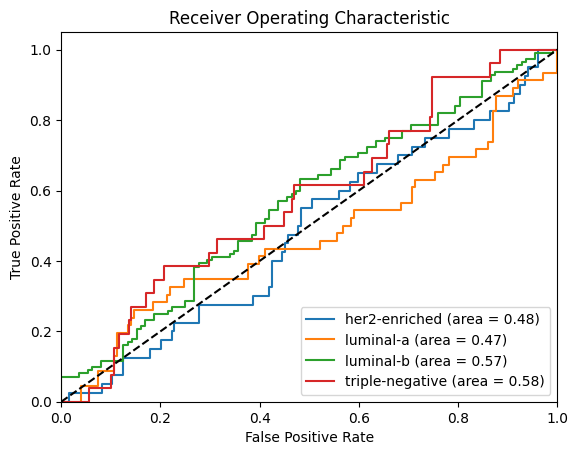

In [17]:
# Plot ROC curve

import matplotlib.pyplot as plt

fpr = dict()

tpr = dict()

roc_auc = dict()

for i in range(len(classes)):

    fpr[i], tpr[i], _ = roc_curve(np.array(y_true) == i, np.array(y_prob)[:, i])

    roc_auc[i] = roc_auc_score(np.array(y_true) == i, np.array(y_prob)[:, i])

    plt.plot(fpr[i], tpr[i], label=f'{classes[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')

plt.xlim([0.0, 1.0])

plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')

plt.ylabel('True Positive Rate')

plt.title('Receiver Operating Characteristic')

plt.legend(loc="lower right")

plt.show()
